In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.integrate import odeint
import scipy
from sklearn.model_selection import train_test_split


In [2]:
def toggle_switch(yz, t, beta_y, beta_z, n_x, n_y, Km1, Km2, delta):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    """
    # Unpack y and z
    y, z = yz

    # Compute dy/dt
    dy_dt = beta_y/ (1 + (z/Km1)**n_x) - delta*y
    
    # Compute dz/dt
    dz_dt = beta_z/ (1 + (y/Km2)**n_y) - delta*z
    
    
    # Return the result as a NumPy array
    return np.array([dy_dt, dz_dt])

In [3]:
def general_toggle_switch(yz, t, *args):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    """
    #args = (np.array(args).reshape(2, 6))
    args1 = np.array([args[0], args[1], args[2], args[3]])
    args2 = np.array([args[4], args[5], args[6], args[7]])#, args[5], args[12], args[13]])
    
    # Unpack y and z
    y, z = yz
    
    # Compute dy/dt
    dy_dt = generalized_hill_function(z, args1) - args1[3]*y
    
    # Compute dz/dt
    dz_dt = generalized_hill_function(y, args2) - args2[3]*z
    
    # Return the result as a NumPy array
    return np.array([dy_dt, dz_dt])

In [4]:
def generalized_hill_function(y, args):
    b    = args[0]
    n    = args[1]
    beta  = args[2]
    return beta/(1 + b*y**n)

In [5]:
def residuals(p):
    p = tuple(p)
    for i in range(0, len(train_list)):
        if not i:
            sim_P = odeint(general_toggle_switch, iv_list[i], t, args = p).T
        else:
            sim_P = np.hstack([sim_P, odeint(general_toggle_switch, iv_list[i], t, args = p).T])
    #print(exp_P.shape)
    #print(sim_P.shape)
    res = (sim_P - exp_P)**2
    #print(np.sum(res.flatten()**2))
    return res.flatten()

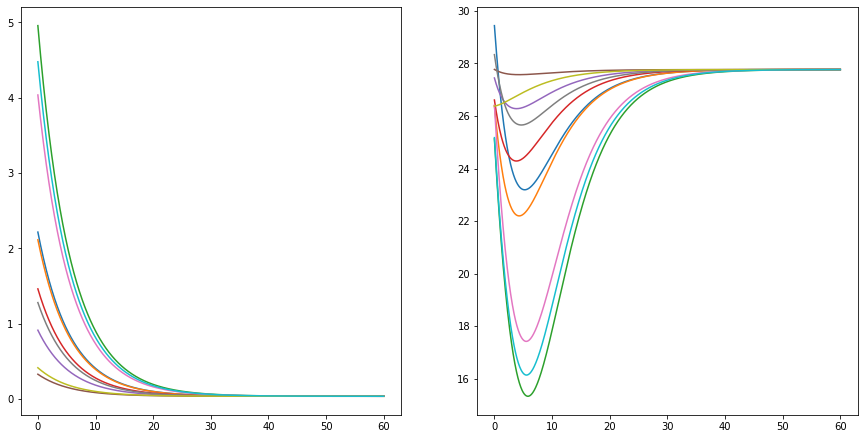

In [7]:
# Number of time points we want for the solutions
n = 1000

# Time points we want for the solution
t = np.linspace(0, 60, n)
iv_list = []
num_ic  = 20
yz_ref = []
ic_range = 100
# Initial condition
for i in range(0, num_ic):
    iv = yz_0 = np.array([np.random.uniform(0, 5), np.random.uniform(25, 30)])
    iv_list.append(iv)
# Parameters
beta_y = 5.0
beta_z = 5.0
n_x = 2
n_y = 2
x_0 = 2.0
Km1 = 1
Km2 = 2
delta = 0.18

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))


#yz_scaled_ref = np.zeros((2, t.shape[0]))
# Package parameters into a tuple
args = (beta_y, beta_z, n_x, n_y, Km1, Km2, delta)


split = train_test_split(iv_list, shuffle=True, test_size=0.5)
train_list = split[0]
test_list = split[1]

# Integrate ODES
for i in range(0, len(train_list)):
    yz_og = scipy.integrate.odeint(toggle_switch, train_list[i], t, args=args).T
    
    y_og, z_og = yz_og[0], yz_og[1]

    y_og_scaled = []
    z_og_scaled = []

    if not i:
        yz_ref = yz_og
    else:
        yz_ref = np.hstack([yz_ref, yz_og])

    ax1.plot(t, y_og)
    ax2.plot(t, z_og)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler1.fit(yz_ref[0].T.reshape(-1, 1))
scaler2.fit(yz_ref[1].T.reshape(-1, 1))
y_ref_scaled = scaler1.transform(yz_ref[0].T.reshape(-1, 1)) + np.abs(np.min(scaler1.transform(yz_ref[0].T.reshape(-1, 1))))
z_ref_scaled = scaler2.transform(yz_ref[1].T.reshape(-1, 1)) + np.abs(np.min(scaler2.transform(yz_ref[1].T.reshape(-1, 1))))

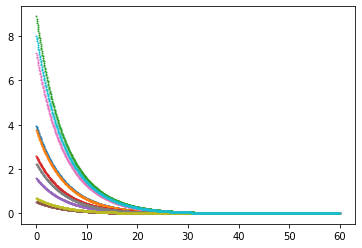

In [9]:
for data in y_ref_scaled.reshape(int(0.5*num_ic), n):
    plt.scatter(t, data, s = 1)
    #plt.plot(t, data[1])

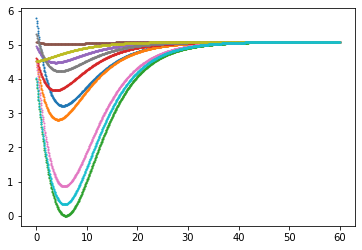

In [10]:
for data in z_ref_scaled.reshape(int(0.5*num_ic), n):
    plt.scatter(t, data, s = 1)
    #plt.plot(t, data[1])

In [25]:
exp_P = np.array(list(zip(y_ref_scaled, z_ref_scaled))).T[0]

In [26]:
exp_P.shape

(2, 1000)

In [27]:
initial_guess = [2, 2, 5, 0.1, 2, 2, 5, 0.1]
fitted_params = least_squares(residuals, initial_guess, bounds=(0, np.inf), method = 'trf', max_nfev=10000, verbose=2, ftol=1e-012, xtol=1e-012).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4217e+09                                    5.41e+10    
       1              2         2.7336e+08      1.15e+09       4.74e+00       7.58e+09    
       2              3         4.2193e+07      2.31e+08       4.52e+00       9.95e+08    
       3              4         1.2374e+07      2.98e+07       4.18e+00       1.70e+08    
       4              5         3.5621e+06      8.81e+06       1.19e-01       2.64e+07    
       5              6         1.9451e+06      1.62e+06       3.76e+00       6.85e+06    
       6              7         1.2460e+06      6.99e+05       3.97e+00       2.02e+06    
       7              8         7.5195e+05      4.94e+05       5.49e+00       1.77e+06    
       8              9         5.8429e+05      1.68e+05       2.92e+00       3.52e+05    
       9             10         3.5047e+05      2.34e+05       1.12e+01       6.70e+04    

/Users/dennisjoshy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


      15             19         2.2921e+05      2.97e+03       3.96e-01       6.00e+03    
      16             23         2.2920e+05      1.37e+01       6.44e-03       5.32e+04    
      17             24         2.2914e+05      5.95e+01       6.25e-03       5.90e+03    
      18             25         2.2910e+05      3.76e+01       6.45e-03       5.84e+03    
      19             26         2.2903e+05      7.52e+01       1.28e-02       5.87e+03    
      20             27         2.2888e+05      1.49e+02       2.58e-02       5.72e+03    
      21             28         2.2858e+05      2.94e+02       5.12e-02       5.75e+03    
      22             29         2.2805e+05      5.38e+02       1.03e-01       7.58e+04    
      23             30         2.2694e+05      1.10e+03       2.03e-01       5.60e+03    
      24             31         2.2502e+05      1.93e+03       4.10e-01       4.28e+03    
      25             32         2.2194e+05      3.07e+03       8.16e-01       1.10e+04    

In [56]:
sim_P[0].shape

(2, 10000)

In [48]:
fitted_params

array([1.02729095e+00, 1.85831049e+00, 2.58267514e-02, 1.08297997e-01,
       3.27032789e-01, 9.14333921e-01, 9.84450885e+01, 2.36804171e+01])

In [49]:
plt.plot(t, exp_P[0], 'ro')
plt.plot(t, odeint(general_toggle_switch, iv, t, args = tuple(initial_guess)).T[0], 'g-')
plt.plot(t, odeint(general_toggle_switch, iv, t, args = tuple(fitted_params)).T[0], 'b-')
plt.legend(['Experimental Data', 'Initial Guess', 'Fitted Parameters'], loc = 'best')
plt.xlabel('Time')
plt.ylabel('Product Concentration')
plt.show()

NameError: name 'exp_P' is not defined

In [ ]:
plt.plot(t, exp_P[1], 'ro')
plt.plot(t, odeint(general_toggle_switch, iv, t, args = tuple(initial_guess)).T[1], 'g-')
plt.plot(t, odeint(general_toggle_switch, iv, t, args = tuple(fitted_params)).T[1], 'b-')
plt.legend(['Experimental Data', 'Initial Guess', 'Fitted Parameters'], loc = 'best')
plt.xlabel('Time')
plt.ylabel('Product Concentration')
plt.show()

In [50]:
a1_node1 = 0
a1_node2 = 0
a2_node1 = 0
a2_node2 = 0
b1_node1 = 0
b1_node2 = 0
b2_node1 = 0
b2_node2 = 0
    
b1_node1 = fitted_params[0]
b1_node2 = fitted_params[4]
n1 = fitted_params[1]
n2 = fitted_params[5]
beta_node1 = fitted_params[2]
beta_node2 = fitted_params[6]
delta_node1 = fitted_params[3]
delta_node2 = fitted_params[7]



KeyError: 0

# Node 1

In [ ]:
from IPython.display import Latex

Latex('$\dot{x}_1 ='+str(beta_node1)+' \\frac{1+'+str((a1_node1))+'x_1^{'+str((n1))+'}+'+str((a2_node1))+'x_2^{'+str((n2))+'}}{1+'+str((b1_node1))+'x_1^{'+str((n1))+'}+'+str((b2_node1))+'x_2^{'+str((n2))+'}} - ' + str(delta_node1)+'x_1 $')

In [ ]:
Latex('$\dot{x}_2 = '+str(beta_node2)+'\\frac{1+'+str((a1_node2))+'x_1^{'+str((n1))+'}+'+str((a2_node2))+'x_2^{'+str((n2))+'}}{1+'+str((b1_node2))+'x_1^{'+str((n1))+'}+'+str((b2_node2))+'x_2^{'+str((n2))+'}} - ' + str(delta_node2)+'x_2 $')

In [ ]:
fitted_params